**루브릭 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.**  
3가지 이상의 모델이 성공적으로 시도됨  
-> 3가지 방법(`LSTM`, `1D-CNN`, `GlobalMaxPooling`)으로 모델을 구성했고, 잘 나왔습니다.

**루브릭 2. `gensim`을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.**  
gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함

-> word2vec_ko.model 파일을 찾을 수 없어 하지 못했습니다.

**루브릭 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.**  
네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

-> 84% 이하를 밑돕니다.

2022/10/19 (수)  
 - 마감기한은 어제(18일, 화요일)였습니다만, 다 마무리하지 못했습니다.
 - github 주소를 일단 올려놓은 상태이고, 추가적으로 작업하고 있습니다.
 - 오늘 안으로는 어떻게든 완성본으로 바꾸어놓겠습니다.
 - 마감기한까지 내지 못하였으니 바로 채점을 하셔도 될 것이고 (아마 루브릭을 하나도 받지 못할 것 같습니다.) 혹시라도 감점을 감수하고 조금 더 내용을 채울 수 있다고 하면, 오늘까지는 완성본으로 만들어놓겠습니다.
 - 어떻게 채점하시건 상관없이, 제 공부를 위해, 이 깃허브 주소의 jupyter notebook은 계속 업데이트해나갈 예정입니다.
 - 번거롭게 해드려 죄송합니다.

# 목차

### 1. 사전작업
#### 1.1. 모듈 불러오기
#### 1.2. 데이터 불러오기
#### 1.3. 중복된 데이터 제거
#### 1.4. 결측치 제거
#### 1.5. 온점 및 구두점 제거
#### 1.6. 불용어(stopwords) 제거 및 형태소 분해
#### 1.7. `word_to_index`
#### 1.8. 토큰화 (words → vectors)

### 2. 모델 생성 및 학습 (`word_to_index`)
#### 2.1. LSTM 모델
#### 2.2. 1D CNN 모델
#### 2.3. `GlobalMaxPooling` 모델
#### 2.4. 유사단어 출력하기

### 3. 모델 생성 및 학습 (`word2vec`)
#### 3.1. 모델 불러오기
#### 3.2. LSTM 모델
#### 3.3. 1D CNN 모델
#### 3.4. `GlobalMaxPooling` 모델
#### 3.5. 유사단어 출력하기

# 1. 사전작업

## 1.1. 모듈 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, os, copy
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

## 1.2. 데이터 불러오기

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 1.3. 중복된 데이터 제거

In [3]:
print(type(train_data))
print(type(test_data))
print(train_data.shape)
print(test_data.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(150000, 3)
(50000, 3)


In [4]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

In [5]:
print(train_data.shape)
print(test_data.shape)

(146183, 3)
(49158, 3)


## 1.4. 결측치 제거

In [6]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    1
label       0
dtype: int64
id          0
document    1
label       0
dtype: int64


In [7]:
train_data.loc[train_data['document'].isna()]

,id,document,label
25857,2172111,NaN,1


In [8]:
test_data.loc[test_data['document'].isna()]

,id,document,label
5746,402110,NaN,1


In [9]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [10]:
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id          0
document    0
label       0
dtype: int64
id          0
document    0
label       0
dtype: int64


In [11]:
print(train_data.shape)
print(test_data.shape)

(146182, 3)
(49157, 3)


## 1.5. 온점 및 구두점 등 제거

In [12]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

/tmp/ipykernel_62/2798799149.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_62/2798799149.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [14]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
test_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())
print(test_data.isnull().sum())

/tmp/ipykernel_62/4202506870.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id            0
document    789
label         0
dtype: int64
id            0
document    305
label         0
dtype: int64


/tmp/ipykernel_62/4202506870.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [15]:
train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')
print(train_data.shape)
print(test_data.shape)

(145393, 3)
(48852, 3)


## 1.6. 불용어(stopwords) 제거 및 형태소 분해

In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [17]:
okt = Okt()
okt.morphs('와 이런 것도 영화라고 차라리 뮤직비디오를 만드는 게 나을 뻔', stem = True)

['오다', '이렇다', '것', '도', '영화', '라고', '차라리', '뮤직비디오', '를', '만들다', '게', '나다', '뻔']

In [18]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [08:07<00:00, 298.27it/s]


In [19]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [20]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [02:58<00:00, 273.47it/s]


In [21]:
X_train_copied = copy.deepcopy(X_train)
X_test_copied = copy.deepcopy(X_test)

In [22]:
print(type(X_train))
print(type(X_test))
print(len(X_train))
print(len(X_test))

<class 'list'>
<class 'list'>
145393
48852


In [23]:
# X_train, X_test의 실행시간이 너무 많이 걸리므로, X_train과 X_test를
# 다시 초기화하고 싶으면 이 셀을 실행하면 된다.
X_train = X_train_copied
X_test = X_test_copied

## 1.7. `word_to_index`

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [25]:
word_to_index = tokenizer.word_index
word_to_index_copied = copy.deepcopy(word_to_index)
index_to_word = {index:word for word, index in word_to_index.items()}
print(word_to_index['영화'])
print(index_to_word[1])

1
영화


In [26]:
print(type(word_to_index))
print(len(word_to_index))

<class 'dict'>
43752


In [27]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

frequent_words=[]

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
    else:
        frequent_words.append(key)

word_to_index = {key:word_to_index[key] for key in frequent_words}
index_to_word = {index:word for word, index in word_to_index.items()}

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt))
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq))
print(len(frequent_words))

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 0.5562488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.018715872104872903
19415


In [28]:
print(len(word_to_index))
print(len(index_to_word))

19415
19415


In [29]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19416


## 1.8. 토큰화 (words → vectors)

In [30]:
print(type(X_train))
print(X_train[0])
print(X_train[1])
print(X_train[2])

<class 'list'>
['아', '더빙', '진짜', '짜증나다', '목소리']
['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다']
['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']


In [31]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [32]:
print(type(X_train))
print(X_train[0])
print(X_train[1])
print(X_train[2])
print(len(X_train))

<class 'list'>
[50, 454, 16, 260, 659]
[933, 457, 41, 602, 1, 214, 1449, 24, 961, 675, 19]
[386, 2444, 2315, 5671, 2, 222, 9]
145393


In [33]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [34]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

145393
48852
145393
48852


In [35]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]
print(len(drop_train))
print(len(drop_test))

231
107


In [36]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

145162
145162
48745
48745


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 69
리뷰의 평균 길이 : 10.812485361182679


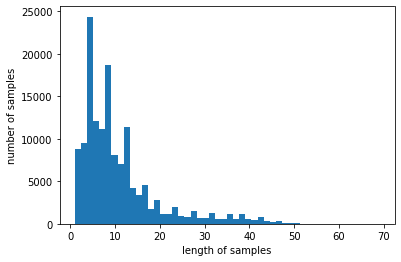

In [37]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [39]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.31944999380003


In [40]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(145162, 30)
(48745, 30)
(145162,)
(48745,)


# 2. 모델 생성 및 학습 (`word_to_index`)

In [42]:
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다
epochs = 20

## 2.1. LSTM 모델

In [43]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = model1.fit(X_train,y_train,epochs=epochs,batch_size=512,
                    validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
284/284 [==============================] - 11s 8ms/step - loss: 0.4917 - accuracy: 0.7780 - val_loss: 0.3739 - val_accuracy: 0.8395
Epoch 2/20
284/284 [==============================] - 2s 6ms/step - loss: 0.3366 - accuracy: 0.8590 - val_loss: 0.3626 - val_accuracy: 0.8426
Epoch 3/20
284/284 [==============================] - 2s 6ms/step - loss: 0.3089 - accuracy: 0.8737 - val_loss: 0.3655 - val_accuracy: 0.8427
Epoch 4/20
284/284 [==============================] - 2s 6ms/step - loss: 0.2921 - accuracy: 0.8817 - val_loss: 0.3700 - val_accuracy: 0.8417
Epoch 5/20
284/284 [==============================] - 2s 6ms/step - loss: 0.2777 - accuracy: 0.8890 - val_loss: 0.3757 - val_accuracy: 0.8408
Epoch 6/20
284/284 [==============================] - 2s 6ms/step - loss: 0.2635 - accuracy: 0.8954 - val_loss: 0.3841 - val_accuracy: 0.8412
Epoch 7/20
284/284 [==============================] - 2s 6ms/step - loss: 0.2486 - accuracy: 0.9031 - val_loss: 0.3969 - val_accuracy: 0.8397
Epoch

1524/1524 - 3s - loss: 0.7550 - accuracy: 0.8242
[0.7550098299980164, 0.8241870999336243]


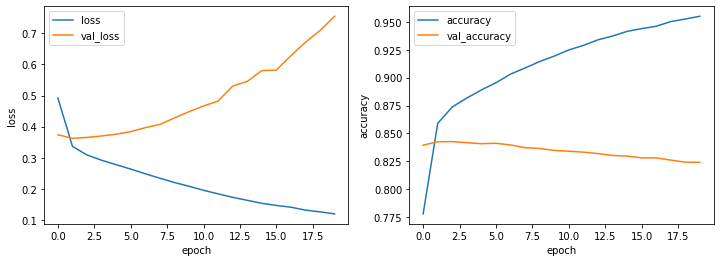

In [44]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

## 2.2. 1D-CNN 모델

In [45]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(145162, 30)
(145162,)
(48745, 30)
(48745,)


In [46]:
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model2.add(tf.keras.layers.MaxPooling1D(5))
model2.add(tf.keras.layers.Conv1D(16, 3, activation='relu'))
model2.add(tf.keras.layers.GlobalMaxPooling1D())
model2.add(tf.keras.layers.Dense(8, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = model2.fit(X_train,y_train,epochs=epochs,batch_size=512,
                    validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
284/284 [==============================] - 4s 7ms/step - loss: 0.5861 - accuracy: 0.6636 - val_loss: 0.5029 - val_accuracy: 0.7345
Epoch 2/20
284/284 [==============================] - 1s 5ms/step - loss: 0.4591 - accuracy: 0.7650 - val_loss: 0.4960 - val_accuracy: 0.7393
Epoch 3/20
284/284 [==============================] - 1s 5ms/step - loss: 0.4135 - accuracy: 0.7904 - val_loss: 0.5092 - val_accuracy: 0.7372
Epoch 4/20
284/284 [==============================] - 1s 5ms/step - loss: 0.3700 - accuracy: 0.8159 - val_loss: 0.5381 - val_accuracy: 0.7334
Epoch 5/20
284/284 [==============================] - 1s 5ms/step - loss: 0.3260 - accuracy: 0.8383 - val_loss: 0.5752 - val_accuracy: 0.7276
Epoch 6/20
284/284 [==============================] - 1s 5ms/step - loss: 0.2879 - accuracy: 0.8549 - val_loss: 0.6293 - val_accuracy: 0.7251
Epoch 7/20
284/284 [==============================] - 1s 5ms/step - loss: 0.2595 - accuracy: 0.8662 - val_loss: 0.7042 - val_accuracy: 0.7222
Epoch 

1524/1524 - 3s - loss: 1.4009 - accuracy: 0.7053
[1.4008936882019043, 0.7053031325340271]


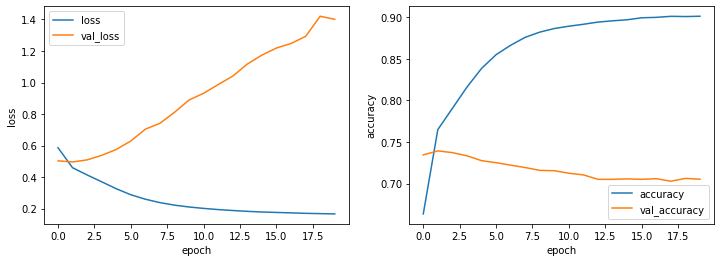

In [47]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

## 2.3. `GlobalMaxPooling` 모델

In [48]:
model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.GlobalMaxPooling1D())
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = model3.fit(X_train,y_train,epochs=epochs,batch_size=512,
                    validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
284/284 [==============================] - 2s 5ms/step - loss: 0.5253 - accuracy: 0.7741 - val_loss: 0.3883 - val_accuracy: 0.8313
Epoch 2/20
284/284 [==============================] - 1s 4ms/step - loss: 0.3434 - accuracy: 0.8536 - val_loss: 0.3596 - val_accuracy: 0.8437
Epoch 3/20
284/284 [==============================] - 1s 4ms/step - loss: 0.2961 - accuracy: 0.8770 - val_loss: 0.3585 - val_accuracy: 0.8451
Epoch 4/20
284/284 [==============================] - 1s 4ms/step - loss: 0.2631 - accuracy: 0.8934 - val_loss: 0.3657 - val_accuracy: 0.8441
Epoch 5/20
284/284 [==============================] - 1s 4ms/step - loss: 0.2355 - accuracy: 0.9072 - val_loss: 0.3789 - val_accuracy: 0.8421
Epoch 6/20
284/284 [==============================] - 1s 4ms/step - loss: 0.2103 - accuracy: 0.9187 - val_loss: 0.3966 - val_accuracy: 0.8407
Epoch 7/20
284/284 [==============================] - 1s 4ms/step - loss: 0.1881 - accuracy: 0.9297 - val_loss: 0.4173 - val_accuracy: 0.8383
Epoch 

1524/1524 - 2s - loss: 0.7969 - accuracy: 0.8147
[0.796862006187439, 0.8147296905517578]


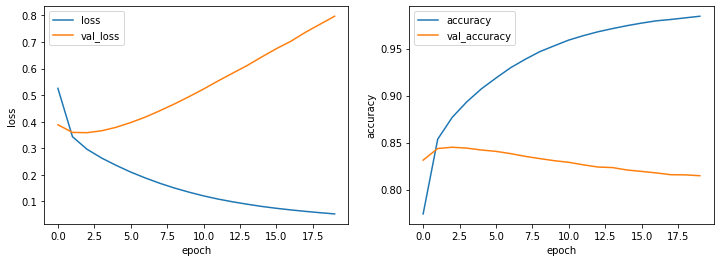

In [49]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

In [50]:
embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)    # shape: (vocab_size, embedding_dim)

(19416, 32)


## 2.4. 유사단어 출력하기

In [51]:
def similarity_test(model_name = model1, test_word = "사랑"):
    word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec'+str(model_name)+'.txt'
    f = open(word2vec_file_path, 'w')
    f.write('{} {}\n'.format(vocab_size-1, word_vector_dim))
    vectors = model_name.get_weights()[0]
    for i in range(1,vocab_size):
        f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
    f.close()
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    return word_vectors.similar_by_word(test_word)

In [52]:
similarity_test(model1, "사랑")

[('명연기', 0.9189034700393677),
 ('사이버', 0.9112342000007629),
 ('꼭대기', 0.9104328155517578),
 ('만으로도', 0.895895779132843),
 ('조제', 0.8952504396438599),
 ('굿', 0.8939908146858215),
 ('엄연하다', 0.8929310441017151),
 ('인생관', 0.8928101658821106),
 ('견고하다', 0.8920180201530457),
 ('활발하다', 0.8914399147033691)]

In [53]:
similarity_test(model2, "사랑")

[('볼맛', 0.7075697779655457),
 ('조권', 0.6927550435066223),
 ('마이클', 0.6871044635772705),
 ('왕중', 0.6493877172470093),
 ('백치', 0.6335142850875854),
 ('와우', 0.6329187154769897),
 ('따땃해', 0.6251872181892395),
 ('찌들다', 0.5987401008605957),
 ('라푼젤', 0.592509388923645),
 ('에게는', 0.5863227248191833)]

In [54]:
similarity_test(model3, "사랑")

[('존경', 0.7622214555740356),
 ('그', 0.7577699422836304),
 ('정말', 0.7331487536430359),
 ('밉다', 0.7308054566383362),
 ('데모', 0.7242238521575928),
 ('그리고', 0.7237205505371094),
 ('메시지', 0.7215903401374817),
 ('스튜어트', 0.7209070920944214),
 ('서다', 0.72003573179245),
 ('유희', 0.7173448801040649)]

# 3. 모델 생성 및 학습 (`word2vec`)

## 3.1. 모델 불러오기

In [55]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'

In [56]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']

In [57]:
# f = open(word2vec_file_path, 'w')
#     f.write('{} {}\n'.format(vocab_size-1, word_vector_dim))
#     vectors = model_name.get_weights()[0]
#     for i in range(1,vocab_size):
#         f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
#     f.close()
#     word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
#     return word_vectors.similar_by_word(test_word)

In [58]:
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

NameError: name 'word2vec' is not defined

## 3.2. LSTM 모델

In [ ]:
word_vector_dim = 32  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다
epochs = 20

## 2.1. LSTM 모델

In [ ]:
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model1.add(tf.keras.layers.Dense(8, activation='relu'))
model1.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

hist = model1.fit(X_train,y_train,epochs=epochs,batch_size=512,
                    validation_data=(X_test, y_test),verbose=1)

In [ ]:
plt.rcParams["figure.figsize"] = (12,4)
plt.subplot(121)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'])

plt.subplot(122)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['accuracy','val_accuracy'])

results = model1.evaluate(X_test,  y_test, verbose=2)

print(results)

## 3.3. 1D CNN 모델

## 3.4. `GlobalMaxPooling` 모델

## 3.5. 유사단어 출력하기